# Experiments with the CPAC10S_S02_v2 dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC10S_S02/CPAC10S_S02_v2.csv")
df_orig.describe()

,M_Trial_Num,M_Mass,M_Mass_to_L5S1,M_sub_task_indices,M_sub_task_num,M_include_overall,T_Pelvis_Moment_X,T_Pelvis_Moment_Y,T_Pelvis_Moment_Z,T_L4L5_compression,...,M_Index,M_sub_task_num_overall,M_sub_task_max,M_sub_task_max_index,M_Index_overall,RWE_cos_L5S1_jointAngle_Z_FE,RWE_sin_L5S1_jointAngle_Z_FE,RWE_sinL5S1_FEx_FORCETOT,RWE_sinL5S1_FE_x_FORCETOT,RWE_L5S1_FE_x_FORCETOT
count,191723.000000,191723.000000,150020.000000,191723.000000,191723.000000,191723.000000,180841.000000,180841.000000,180841.000000,180841.000000,...,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.0,191723.000000,191723.000000
mean,69.634436,10.490995,0.306271,271.601456,5.498271,0.826943,-77.496659,7.374778,-0.764658,2324.028389,...,2633.098079,229.780877,-0.410644,0.002128,95862.000000,0.010021,-0.044757,0.0,-45.617567,3688.558359
std,24.585127,5.963444,0.156523,204.444123,4.819731,0.378297,75.374627,31.588712,7.897708,1850.949010,...,2432.654241,122.680911,9.729202,0.046082,55345.807167,0.710689,0.702013,0.0,798.791177,8470.153751
min,1.000000,0.000000,0.100501,1.000000,1.000000,0.000000,-736.123893,-412.307868,-100.862202,-3084.607254,...,1.000000,1.000000,-736.123893,0.000000,1.000000,-1.000000,-1.000000,0.0,-1919.979091,-16958.460716
25%,49.000000,5.000000,0.161602,118.000000,1.000000,1.000000,-139.423624,-7.893999,-4.412268,1093.218082,...,583.000000,118.000000,0.000000,0.000000,47931.500000,-0.710479,-0.743670,0.0,-818.045587,-2574.693383
50%,80.000000,10.000000,0.267931,237.000000,4.000000,1.000000,-52.231431,3.105681,-0.234725,1448.897275,...,1808.000000,245.000000,0.000000,0.000000,95862.000000,0.025466,-0.081086,0.0,-90.130539,1724.697409
75%,88.000000,15.000000,0.446812,377.000000,8.000000,1.000000,-11.005736,23.809360,3.116414,3033.461978,...,4188.000000,332.000000,0.000000,0.000000,143792.500000,0.720393,0.644414,0.0,721.514217,11194.542474
max,96.000000,23.000000,0.700108,1589.000000,18.000000,1.000000,950.996221,134.543500,146.478297,112613.480994,...,10287.000000,429.000000,3.267506,1.000000,191723.000000,1.000000,1.000000,0.0,2023.691070,26943.113314


## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")

def get_trial_column_name(df):
    for column in get_meta_names(df):
        if "TRIAL_NAME" in column.upper():
            return column
        
def get_simulated_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "SW_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "SWE_"))
    return predictors

def get_real_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "RW_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "RWE_"))
    return predictors

trial_name = get_trial_column_name(df_orig)

In [4]:
df_orig[get_meta_names(df_orig)].describe()
# M_Trial_Num
# M_sub_task_num_overall
# M_Index_overall
#  M_Index (scope: trial)
#  M_sub_task_num (scope: trial)
#    M_sub_task_indices (scope: sub task)
#    M_sub_task_max (only for max point), M_sub_task_max_index (1 if max point)

,M_Trial_Num,M_Mass,M_Mass_to_L5S1,M_sub_task_indices,M_sub_task_num,M_include_overall,M_Index,M_sub_task_num_overall,M_sub_task_max,M_sub_task_max_index,M_Index_overall
count,191723.000000,191723.000000,150020.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000,191723.000000
mean,69.634436,10.490995,0.306271,271.601456,5.498271,0.826943,2633.098079,229.780877,-0.410644,0.002128,95862.000000
std,24.585127,5.963444,0.156523,204.444123,4.819731,0.378297,2432.654241,122.680911,9.729202,0.046082,55345.807167
min,1.000000,0.000000,0.100501,1.000000,1.000000,0.000000,1.000000,1.000000,-736.123893,0.000000,1.000000
25%,49.000000,5.000000,0.161602,118.000000,1.000000,1.000000,583.000000,118.000000,0.000000,0.000000,47931.500000
50%,80.000000,10.000000,0.267931,237.000000,4.000000,1.000000,1808.000000,245.000000,0.000000,0.000000,95862.000000
75%,88.000000,15.000000,0.446812,377.000000,8.000000,1.000000,4188.000000,332.000000,0.000000,0.000000,143792.500000
max,96.000000,23.000000,0.700108,1589.000000,18.000000,1.000000,10287.000000,429.000000,3.267506,1.000000,191723.000000


## Clean-up dataset

- Remove samples based on `M_include_overall`

In [14]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df[trial_name].unique())} (before clean-up: {len(df_orig[trial_name].unique())})")
print(f"Number of subtasks: {len(df['M_sub_task_num_overall'].unique())} (before clean-up: {len(df_orig['M_sub_task_num_overall'].unique())})")

Number of samples: 158544 (before clean-up: 191723)
Number of trials: 92 (before clean-up: 93)
Number of subtasks: 406 (before clean-up: 408)


## Train / test partitioning

- Test set: exercises with 5kg weight
- Train set: all other samples

In [6]:
test_selector = df[trial_name].str.match("S0[0-9]_5kg")
#test_selector = df["Trial_Name"].str.contains("freestyle", case=False)
df_test = df[test_selector]
df_train = df[~test_selector]
print(f"Train set size: {len(df_train)}\nTest set size: {len(df_test)} ({len(df_test) / len(df):.1%})")
print(f"Test trials: {df_test[trial_name].unique()}")

Train set size: 141220
Test set size: 17324 (10.9%)
Test trials: ['S01_5kg' 'S02_5kg' 'S03_5kg' 'S05_5kg' 'S06_5kg']


## Show /verify the time series from one test trial
Pick a test trial with the most subtasks

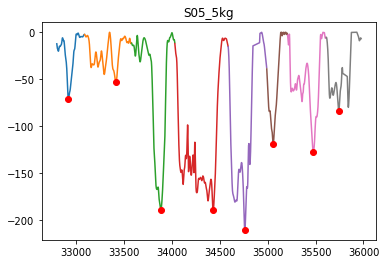

In [7]:
selected_trial = df_test.groupby(trial_name)["M_sub_task_num"].max().idxmax()
selected_series = df_test[df_test[trial_name] == selected_trial].groupby("M_sub_task_num")
#plt.plot(selected_series)
#selected_series.plot();
for selected_sub_task_num, selected_sub_task in selected_series:
    plt.plot(selected_sub_task["T_Pelvis_Moment_X"])
    plt.plot(selected_sub_task[selected_sub_task["M_sub_task_max_index"] == 1]["M_sub_task_max"], "ro")
    
plt.title(selected_trial);

## Train and evaluate boosted tree models


Predicting T_Pelvis_Moment_X from Simulated Wearables:
MSE: 98.31
RMSE: 9.92
R^2 Score: 0.974

Predicting T_Pelvis_Moment_X from Simulated Wearables w/ Explaratory:
MSE: 77.11
RMSE: 8.78
R^2 Score: 0.980

Predicting T_Pelvis_Moment_X from Real Wearables:
MSE: 142.85
RMSE: 11.95
R^2 Score: 0.962

Predicting T_Pelvis_Moment_X from Real Wearables w/ Explaratory:
MSE: 163.09
RMSE: 12.77
R^2 Score: 0.958

Predicting T_Pelvis_Moment_X from Emily's Recipe #1:
MSE: 1957.90
RMSE: 44.25
R^2 Score: -0.048

Predicting T_Pelvis_Moment_X from Emily's Recipe #2:
MSE: 330.43
RMSE: 18.18
R^2 Score: 0.914

Predicting T_Pelvis_Moment_X from Emily's Recipe #3:
MSE: 452.36
RMSE: 21.27
R^2 Score: 0.878

Predicting T_Pelvis_Moment_X from Emily's Recipe #4:
MSE: 298.61
RMSE: 17.28
R^2 Score: 0.920


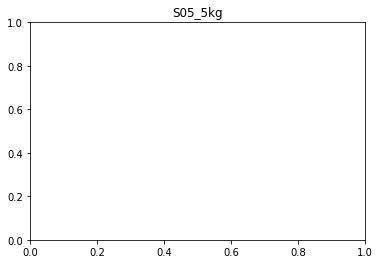

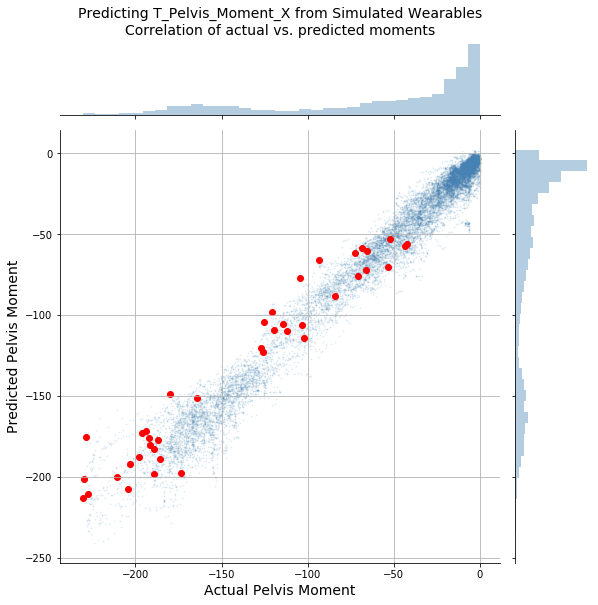

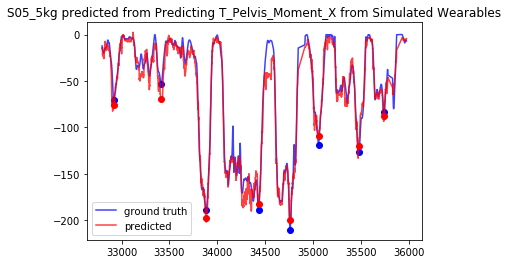

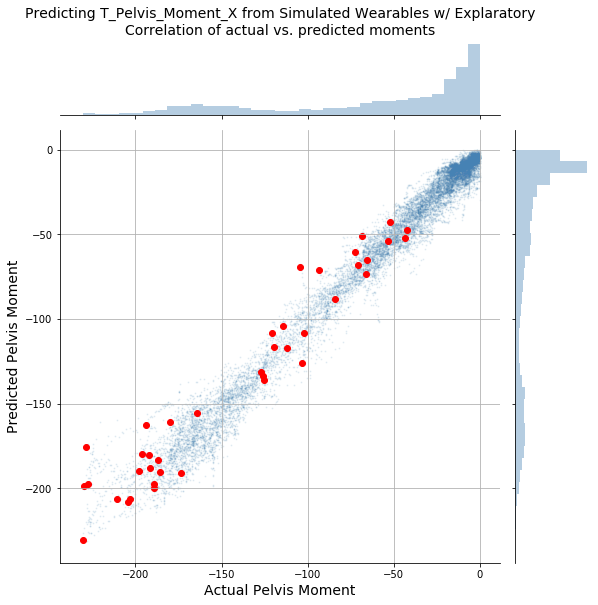

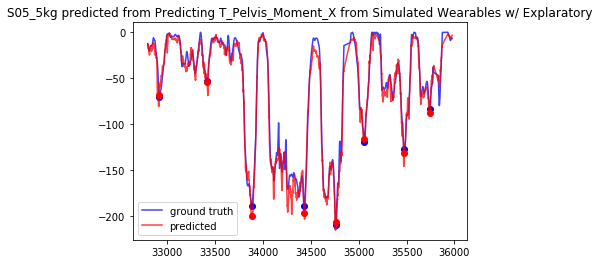

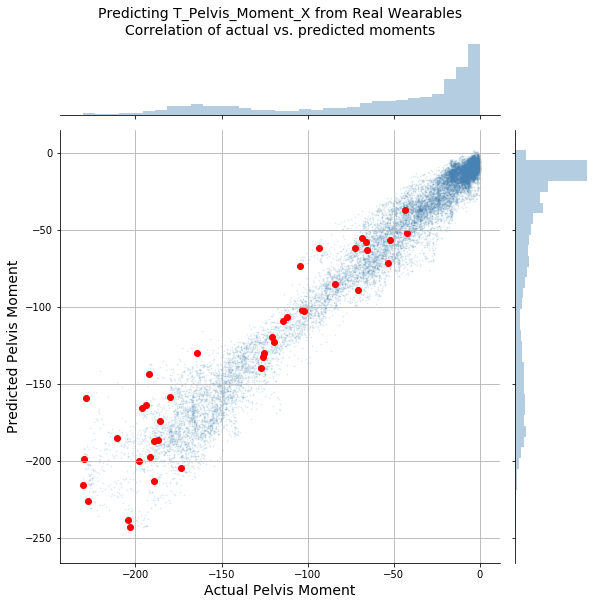

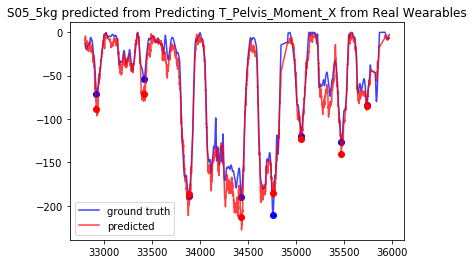

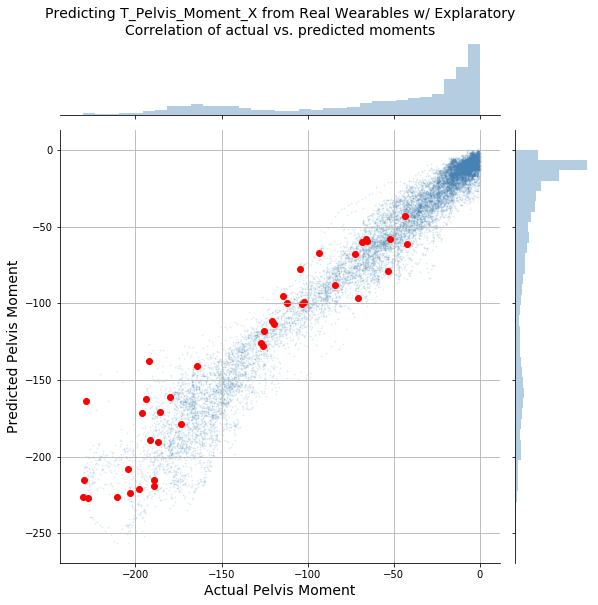

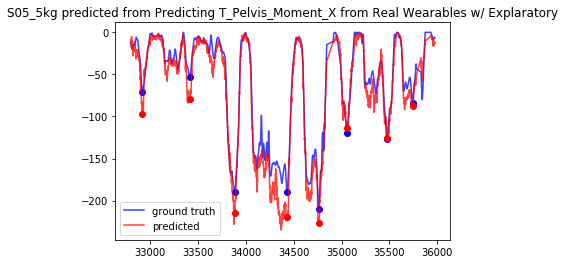

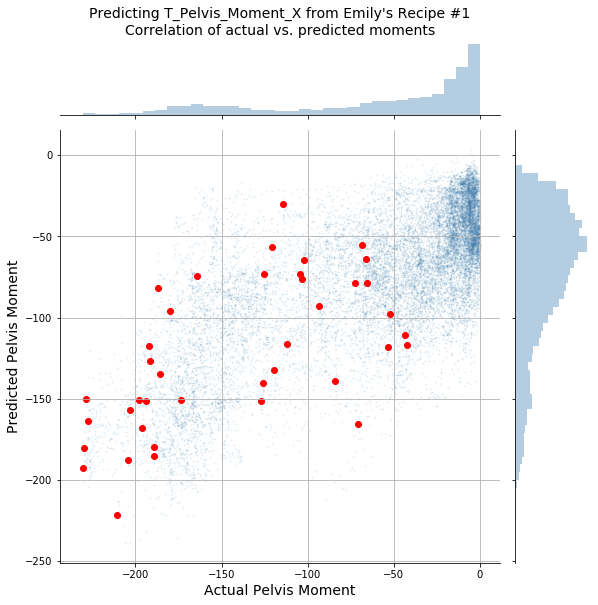

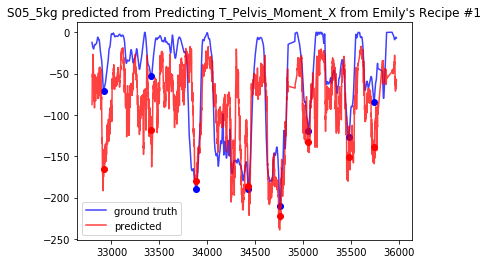

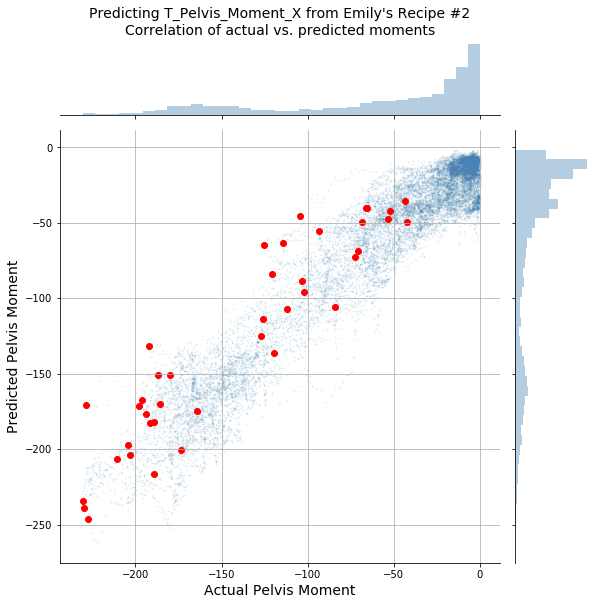

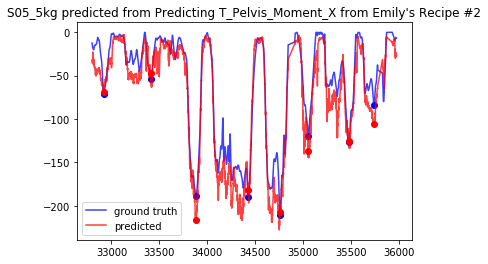

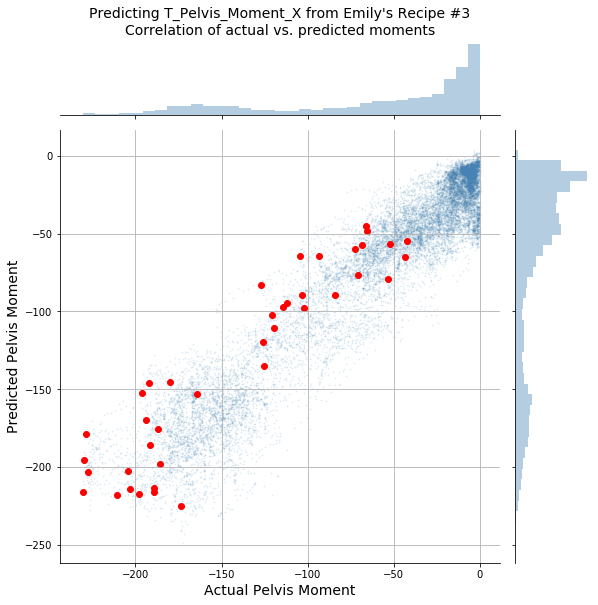

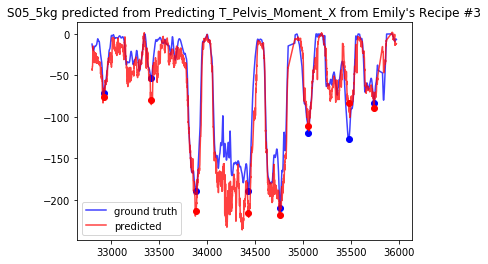

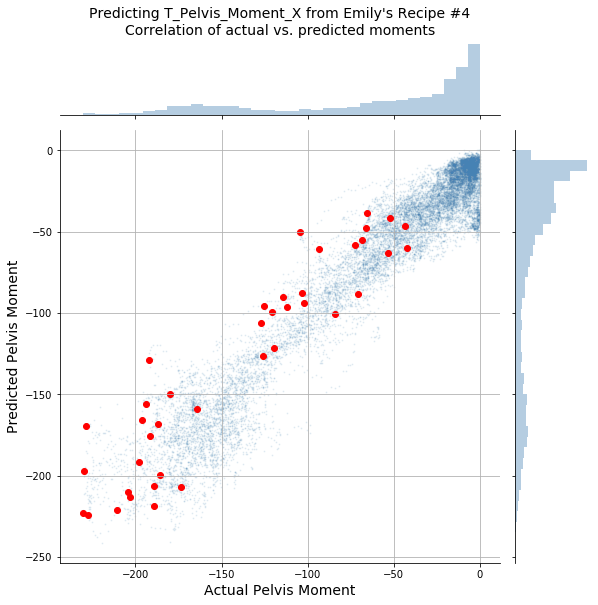

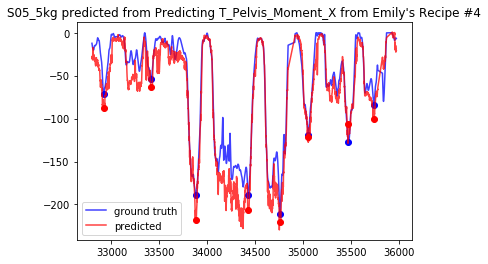

In [8]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor(max_iter=200))
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(title, model, X_test, y_test, meta_test):
    
    print(f"\n{title}:")
    y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)
    
    # Quantitative results
    mse = metrics.mean_squared_error(y_test_pred, y_test)
    r2 = metrics.r2_score(y_test_pred, y_test)
    print(f"MSE: {mse:.2f}\nRMSE: {np.sqrt(mse):.2f}\nR^2 Score: {r2:.3f}")
    
    # Correlation plot: actual vs. predicted
    ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
    #sns.jointplot(y_test, y_test_pred, kind="hex")
    #sns.jointplot(y_test, y_test_pred, kind="reg")
    ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
    #ax.ax_joint.legend_.remove()
    ax.ax_joint.grid()
    ax.ax_marg_x.set_title(f"{title}\nCorrelation of actual vs. predicted moments", fontsize=14)
    max_points = meta_test["M_sub_task_max_index"] == 1
    ax.ax_joint.scatter(y_test[max_points], y_test_pred[max_points], c="red")
    
    plt.figure()
    selected_y = y_test[meta_test[trial_name]==selected_trial]
    selected_maxs = selected_y[meta_test["M_sub_task_max_index"]==1]
    plt.plot(selected_y, 'b-', label="ground truth", alpha=0.75)
    plt.plot(selected_maxs, 'bo')
    
    selected_y_pred = y_test_pred[meta_test[trial_name]==selected_trial]
    selected_maxs_pred = selected_y_pred[meta_test["M_sub_task_max_index"]==1]
    plt.plot(selected_y_pred, 'r-', label="predicted", alpha=0.75)
    plt.plot(selected_maxs_pred, 'ro')
    
    plt.title(f"{selected_trial} predicted from {title}")
    plt.legend()
    
    #    plt.plot(selected_sub_task[selected_sub_task["M_sub_task_max_index"] == 1]["M_sub_task_max"], "bo")
    
plt.title(selected_trial);

feature_sets = {
    "Simulated Wearables": get_simulated_predictors(df, explaratory=False),
    "Simulated Wearables w/ Explaratory": get_simulated_predictors(df, explaratory=True),
    "Real Wearables": get_real_predictors(df, explaratory=False),
    "Real Wearables w/ Explaratory": get_real_predictors(df, explaratory=True),
    "Emily's Recipe #1": [
        'RW_INSOLE_LFORCE',
        'RW_INSOLE_RFORCE',
        'RW_INSOLE_LXMM_ML',
        'RW_INSOLE_LYMM_AP',
        'RW_INSOLE_RXMM_ML',
        'RW_INSOLE_RYMM_AP',
        'RWE_FORCE_TOTAL',
        'RWE_R_Ankle_Moment_sag',
        'RWE_L_Ankle_Moment_sag',
        'RWE_R_Ankle_Moment_fro',
        'RWE_L_Ankle_Moment_fro',
        'RWE_R_Ankle_Moment_fro',
        'RWE_L_Ankle_Moment_fro',
    ],
    "Emily's Recipe #2": [
        'RW_INSOLE_LFORCE',
        'RW_INSOLE_RFORCE',
        'RW_INSOLE_LXMM_ML',
        'RW_INSOLE_LYMM_AP',
        'RW_INSOLE_RXMM_ML',
        'RW_INSOLE_RYMM_AP',
        'RWE_FORCE_TOTAL',
        'RW_L5_orientation_eZ_tra',
        'RW_L5_orientation_eY_sag',
        'RW_L5_orientation_eX_fro',
    ],
    "Emily's Recipe #3": [
        'RW_INSOLE_LFORCE',
        'RW_INSOLE_RFORCE',
        'RW_INSOLE_LXMM_ML',
        'RW_INSOLE_LYMM_AP',
        'RW_INSOLE_RXMM_ML',
        'RW_INSOLE_RYMM_AP',
        'RWE_FORCE_TOTAL',
        'RW_L5S1_jointAngle_X_LB',
        'RW_L5S1_jointAngle_Y_RO',
        'RW_L5S1_jointAngle_Z_FE'
    ],
    "Emily's Recipe #4": [
        'RW_INSOLE_LFORCE',
        'RW_INSOLE_RFORCE',
        'RW_INSOLE_LXMM_ML',
        'RW_INSOLE_LYMM_AP',
        'RW_INSOLE_RXMM_ML',
        'RW_INSOLE_RYMM_AP',
        'RWE_FORCE_TOTAL',
        'RWE_R_Ankle_Moment_sag',
        'RWE_L_Ankle_Moment_sag',
        'RWE_R_Ankle_Moment_fro',
        'RWE_L_Ankle_Moment_fro',
        'RWE_R_Ankle_Moment_fro',
        'RWE_L_Ankle_Moment_fro',
        'RW_L5_orientation_eZ_tra',
        'RW_L5_orientation_eY_sag',
        'RW_L5_orientation_eX_fro',
        'RW_L5S1_jointAngle_X_LB',
        'RW_L5S1_jointAngle_Y_RO',
        'RW_L5S1_jointAngle_Z_FE',
        'RWE_cos_L5S1_jointAngle_Z_FE',
        'RWE_sin_L5S1_jointAngle_Z_FE',
        'RWE_sinL5S1_FEx_FORCETOT',
        'RWE_sinL5S1_FE_x_FORCETOT',
        'RWE_L5S1_FE_x_FORCETOT',
    ],
}

# for target_name in get_target_names(df):
#     for feature_set, feature_names in feature_sets.items():
#         model = train_model(df_train[feature_names], df_train[target_name])
#         title = f"Predicting {target_name} from {feature_set}"
#         evaluate_model(title, model, df_test[feature_names], df_test[target_name], df_test[meta_names])

target_name = "T_Pelvis_Moment_X"
meta_names = get_meta_names(df)
for feature_set, feature_names in feature_sets.items():
    model = train_model(df_train[feature_names], df_train[target_name])
    title = f"Predicting {target_name} from {feature_set}"
    evaluate_model(title, model, df_test[feature_names], df_test[target_name], df_test[meta_names])